In [1]:
import rasterio
import numpy as np
import os

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/esther/qr_for_landcover/scripts')
import landcover_definitions as lc

sys.path.append('../evaluation')
import run_model_forward_and_produce_tifs as run_model

In [2]:
torchgeo_data_dir = '/home/esther/torchgeo_data'
torchgeo_data_dir_cc = '/home/esther/torchgeo_data/cvpr_chesapeake_landcover'
out_dir_figures = 'home/esther/qr_for_landcover/figures'
torchgeo_output_dir = '/home/esther/torchgeo/output'
torchgeo_preds_dir = '/home/esther/torchgeo_predictions'
figure_out_dir = '../figures'
run_dir = '/home/esther/chesepeake_north_qr'

# save q and r as npy so you don't have to recompute every time
if you've already done this once you can skip this step

In [3]:

state = 'pa'
state_descriptor = f'{state}_1m_2013_extended-debuffered-test_tiles'

if state == 'pa':
 state_preds_dir = 'pa_fcn_0.0001_qr_forward_from_cooccurrences_101_31_no_osm_no_buildings_additive_smooth_0.0001_prior_smooth_0.0001'
    
tile_ids = np.unique([x[2:17] for x in os.listdir(os.path.join(torchgeo_data_dir_cc, state_descriptor))])

tile_id = tile_ids[0]

img_fn_this_tile = os.path.join(torchgeo_data_dir_cc, state_descriptor, f'm_{tile_id}_naip-new.tif')
prior_fn_this_tile = os.path.join(torchgeo_data_dir_cc, state_descriptor, f'm_{tile_id}_prior_from_cooccurrences_101_31_no_osm_no_buildings.tif')

fn_preds_this_tile = os.path.join(torchgeo_preds_dir,
                                  state_preds_dir,
                                 'cvpr_chesapeake_landcover',
                                  state_descriptor,
                                  f'm_{tile_id}_qr_forward_pred_last.tif')


with rasterio.open(img_fn_this_tile) as f:
    img = f.read()

with rasterio.open(prior_fn_this_tile) as f:
    prior = f.read()
    prior = prior + 1e-4 / (prior + 1e-4).sum(axis=0)


In [4]:
state = 'pa'
loss = 'qr_forward'
torchgeo_output_dir = '/home/esther/torchgeo/output'
prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'

state_descriptor = f'{state}_1m_2013_extended-debuffered-test_tiles'

run_name = f'{state}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'

ckpt_name = 'last.ckpt'
model_ckpt_fp = os.path.join(torchgeo_output_dir,run_dir,run_name, ckpt_name)
            
tile_ids = np.unique([x[2:17] for x in os.listdir(os.path.join(torchgeo_data_dir_cc, state_descriptor))])
    
state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
data_dir_this_state = f'/home/esther/torchgeo_data/cvpr_chesapeake_landcover/{state_identifier}'
         
image_fns = []
for tile_id in tile_ids[:1]:
    image_fns.append(os.path.join(data_dir_this_state,f'm_{tile_id}_naip-new.tif'))
print(image_fns)
q_pa = run_model.run_through_tiles(model_ckpt_fp,
                                 input_fns=image_fns,
                                 output_fns= [''],
                                model_kwargs = {'in_channels': 4, 'classes': 4, 'num_filters': 128},
                                return_dont_save=True)

['/home/esther/torchgeo_data/cvpr_chesapeake_landcover/pa_1m_2013_extended-debuffered-test_tiles/m_3907614_ne_18_1_naip-new.tif']
0 of 1


In [5]:
with rasterio.open(os.path.join(data_dir_this_state,f'm_{tile_id}_prior_{prior_version}.tif')) as f:
    prior_pa = f.read() 
    prior_pa = (prior + 1e-4) / (prior + 1e-4).sum(0)
with rasterio.open(os.path.join(data_dir_this_state,f'm_{tile_id}_naip-new.tif')) as f:
    img_pa = f.read()
  
np.save(f'figure_data/prior_pa_{tile_id}.npy',prior_pa)
np.save(f'figure_data/q_pa_{tile_id}.npy',q_pa)
np.save(f'figure_data/img_pa_{tile_id}.npy',img_pa)

# PA from npy files

In [6]:
tile_id_pa = '3907614_ne_18_1'
img_pa = np.load(f'figure_data/img_pa_{tile_id_pa}.npy')
q_pa = np.load(f'figure_data/q_pa_{tile_id_pa}.npy')
prior_pa = np.load(f'figure_data/prior_pa_{tile_id_pa}.npy')

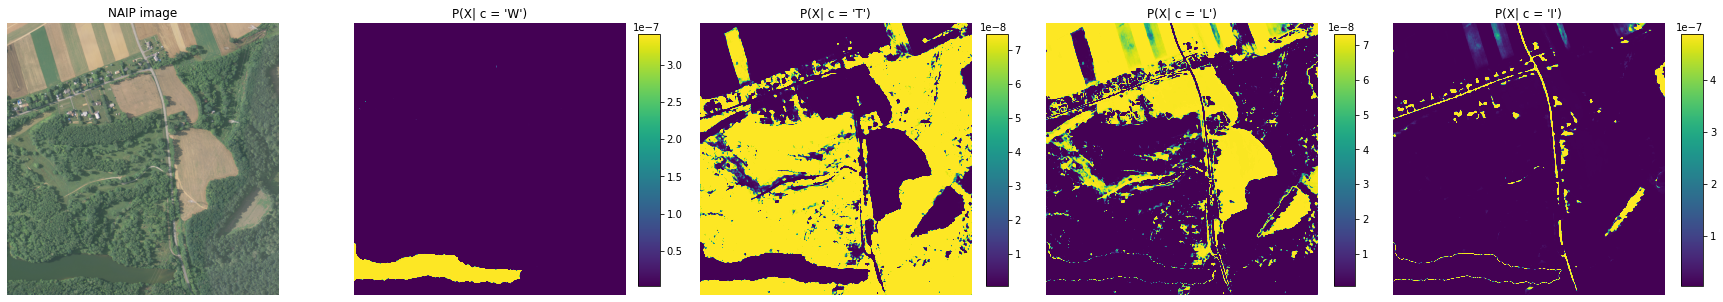

In [7]:
# P(X|C)

p_x_given_c = np.zeros(q_pa.shape)
for c in range(4):
    p_x_given_c[c] = q_pa[c] / q_pa[c].sum(axis=(0,1)) 
    
classes = ['Water', 'Tree/Forest', 'Low vegetation/field', 'Impervious']
fig, ax = plt.subplots(1,5, figsize=(30,5))

h1, h2 = 2000, 3000
w1, w2 = 3000, 4000 

log_probabilities = False

ax[0].imshow(img[:3, h1:h2, w1:w2].T.swapaxes(0,1))
ax[0].set_title('NAIP image')
for c in range(4):    
    
    if log_probabilities:
        a = ax[c+1].imshow(np.log(p_x_given_c[c, h1:h2, w1:w2]), 
                         interpolation = 'none',
                        # vmin=np.log(1e-8), vmax=np.log(1e-6)
                          # cmap='magma'
                           )
        ax[c+1].set_title(f"log( P(X| c = '{classes[c][0]}') )")
    else:
        a = ax[c+1].imshow(p_x_given_c[c, h1:h2, w1:w2], 
                         interpolation = 'none')
    
        ax[c+1].set_title(f"P(X| c = '{classes[c][0]}')")
    
    cbar_ax = fig.add_axes([.421 + .161*c, 0.15, 0.01, 0.7])
    fig.colorbar(a, cax=cbar_ax)


for c in range(5): 
    ax[c].axis('off')
    ax[c].get_xaxis().set_visible(False)
    ax[c].get_yaxis().set_visible(False)


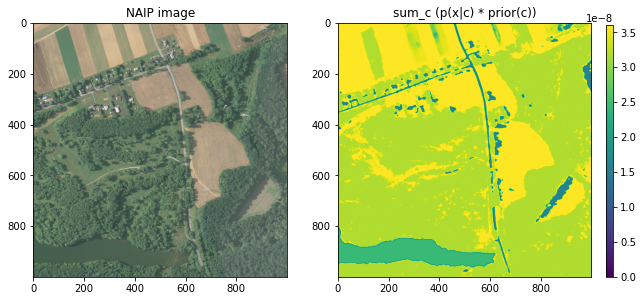

In [8]:
# P(X)
p_x = np.zeros_like(p_x_given_c[0])
for c in range(4):
    p_x += p_x_given_c[c]* prior_pa[c].mean(axis=(0,1))
    

 
fig, ax = plt.subplots(1,2, figsize=(10,5))

h1, h2 = 2000, 3000
w1, w2 = 3000, 4000 


ax[0].imshow(img[:3, h1:h2, w1:w2].T.swapaxes(0,1))
ax[0].set_title('NAIP image')

if log_probabilities:
    a = ax[1].imshow(np.log(p_x[h1:h2, w1:w2].T.swapaxes(0,1)), vmin=0)
    ax[1].set_title('log ( sum_c (p(x|c) * prior(c)))')
else:
    a = ax[1].imshow(p_x[h1:h2, w1:w2].T.swapaxes(0,1), vmin=0)
    ax[1].set_title('sum_c (p(x|c) * prior(c))')
cbar_ax = fig.add_axes([.92, 0.15, 0.01, 0.7])
fig.colorbar(a, cax=cbar_ax)

# Now do NY - again you can skip a few cell if you have the data as np files

In [9]:
state = 'ny'
state_descriptor = f'{state}_1m_2013_extended-debuffered-test_tiles'

state_preds_dir = f'{state}_fcn_0.0001_qr_forward_from_cooccurrences_101_31_no_osm_no_buildings_additive_smooth_0.0001_prior_smooth_0.0001'
    
tile_ids = np.unique([x[2:17] for x in os.listdir(os.path.join(torchgeo_data_dir_cc, state_descriptor))])

In [10]:
loss = 'qr_forward'
prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'

run_name = f'{state}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'

ckpt_name = 'last.ckpt'
model_ckpt_fp = os.path.join(torchgeo_output_dir,run_dir,run_name, ckpt_name)
            
            
state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
data_dir_this_state = f'{torchgeo_data_dir}/cvpr_chesapeake_landcover/{state_identifier}'
         
image_fns = []
for tile_id in tile_ids[9:10]:
    image_fns.append(os.path.join(data_dir_this_state,f'm_{tile_id}_naip-new.tif'))
print(image_fns)
q_ny = run_model.run_through_tiles(model_ckpt_fp,
                                 input_fns=image_fns,
                                 output_fns= [''],
                                model_kwargs = {'in_channels': 4, 'classes': 4, 'num_filters': 128},
                                return_dont_save=True)

['/home/esther/torchgeo_data/cvpr_chesapeake_landcover/ny_1m_2013_extended-debuffered-test_tiles/m_4207539_se_18_1_naip-new.tif']
0 of 1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [11]:
with rasterio.open(os.path.join(data_dir_this_state,f'm_{tile_id}_prior_{prior_version}.tif')) as f:
    prior_ny = f.read() 
    prior_ny = (prior_ny + 1e-4) / (prior_ny + 1e-4).sum(0)
    
with rasterio.open(os.path.join(data_dir_this_state,f'm_{tile_id}_naip-new.tif')) as f:
    img_ny = f.read()


In [12]:
np.save(f'figure_data/prior_ny_{tile_id}.npy',prior_ny)
np.save(f'figure_data/q_ny_{tile_id}.npy',q_ny)
np.save(f'figure_data/img_ny_{tile_id}.npy',img_ny)

# NY from npy files

In [13]:
tile_id_ny = '4207539_se_18_1'
prior_ny = np.load(f'figure_data/prior_ny_{tile_id_ny}.npy')
q_ny = np.load(f'figure_data/q_ny_{tile_id_ny}.npy')
img_ny = np.load(f'figure_data/img_ny_{tile_id_ny}.npy')

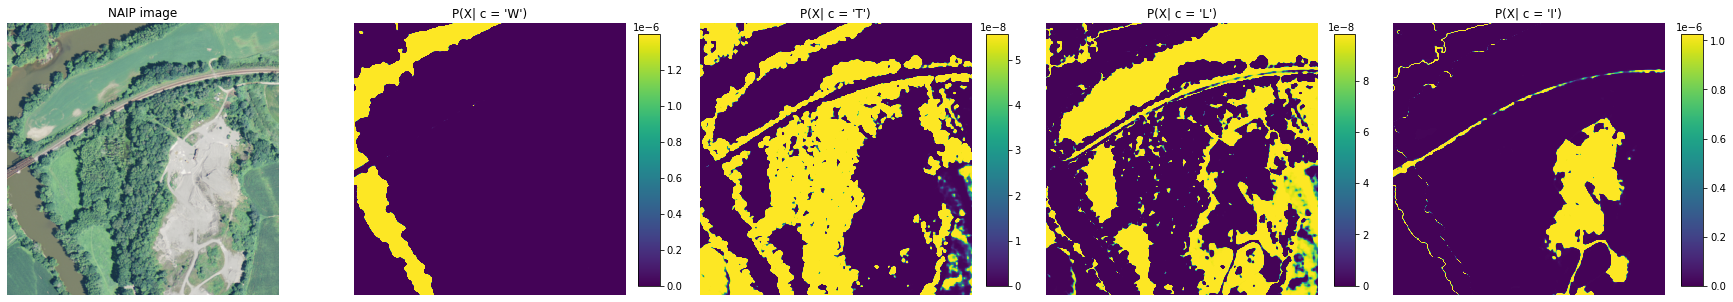

In [14]:
h1, h2 = 4000,4500
w1, w2 = 1500,2000

p_x_given_c = np.zeros(q_ny.shape)
for c in range(4):
    p_x_given_c[c] = q_ny[c] / q_ny[c].sum(axis=(0,1)) 
    
classes = ['Water', 'Tree/Forest', 'Low vegetation/field', 'Impervious']

fig, ax = plt.subplots(1,5, figsize=(30,5))

log_probabilities = False

ax[0].imshow(img_ny[:3, h1:h2, w1:w2].T.swapaxes(0,1))
ax[0].set_title('NAIP image')
for c in range(4):    
    
    if log_probabilities:
        a = ax[c+1].imshow(np.log(p_x_given_c[c, h1:h2, w1:w2]), 
                         interpolation = 'none')
        ax[c+1].set_title(f"log( P(X| c = '{classes[c][0]}') )")
        
    else:
        a = ax[c+1].imshow(p_x_given_c[c, h1:h2, w1:w2], 
                           interpolation = 'none',
                           vmin=0
                          )
        ax[c+1].set_title(f"P(X| c = '{classes[c][0]}')")
        
    cbar_ax = fig.add_axes([.421 + .161*c, 0.15, 0.01, 0.7])
    fig.colorbar(a, cax=cbar_ax)

for c in range(5): 
    ax[c].axis('off')
    ax[c].get_xaxis().set_visible(False)
    ax[c].get_yaxis().set_visible(False)




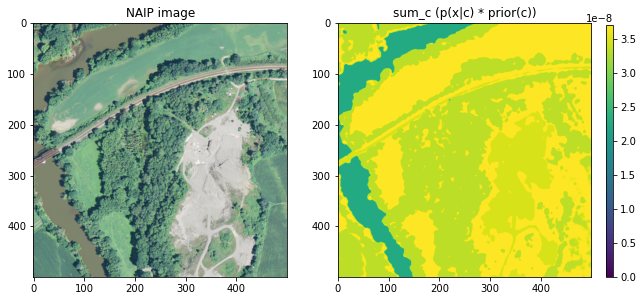

In [15]:
p_x = np.zeros_like(p_x_given_c[0])
for c in range(4):
    p_x += p_x_given_c[c]* prior_ny[c].mean(axis=(0,1))

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img_ny[:3, h1:h2, w1:w2].T.swapaxes(0,1))
ax[0].set_title('NAIP image')

if log_probabilities:
    a = ax[1].imshow(np.log(p_x[h1:h2, w1:w2].T.swapaxes(0,1)),)
    ax[1].set_title('log ( sum_c (p(x|c) * prior(c)))')
else:
    a = ax[1].imshow(p_x[h1:h2, w1:w2].T.swapaxes(0,1), vmin=0)
    ax[1].set_title('sum_c (p(x|c) * prior(c))')
cbar_ax = fig.add_axes([.92, 0.15, 0.01, 0.7])
fig.colorbar(a, cax=cbar_ax)   